In [5]:
import numpy as np
import pickle as pkl
import torch
import umap
import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib import style
import palettable
from palettable.tableau import Tableau_20 as pallette

sns.set()
sns.set_palette(sns.color_palette("colorblind"))

# sns.set_palette(ListedColormap(palette.mpl_colormap))
# style.use('seaborn')


# Visualise Wave-LSTM model output

In [3]:
with open("output-hpc-ascat-clf.pkl", 'rb') as file:
    meta_results = pkl.load(file)

J = len(meta_results["hidden"])
lbls = meta_results["labels"].cpu().numpy()

Mbar = torch.mean(meta_results["M"], axis=1).cpu().numpy()
Mflat = torch.flatten(meta_results["M"], start_dim=1).cpu().numpy()
A = meta_results["attention"]

print(meta_results.keys())

dict_keys(['masked_inputs', 'hidden', 'attention', 'M', 'labels'])


## UMAP of the scale embeddings, and masked inputs

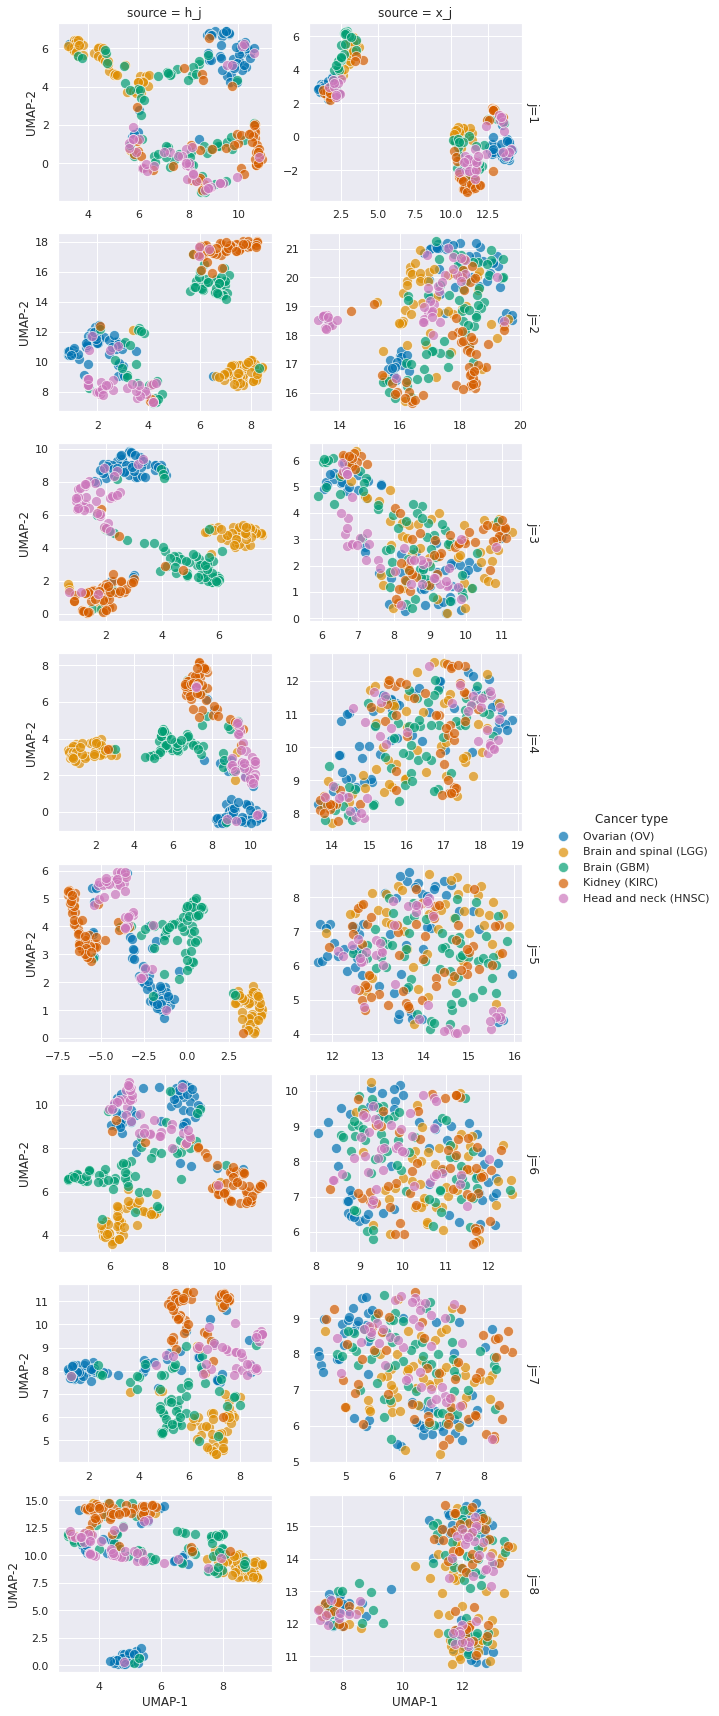

In [63]:
labels = ['Ovarian (OV)', 'Brain (GBM)', 'Kidney (KIRC)', 'Head and neck (HNSC)', 'Brain and spinal (LGG)']
labels_short = ['OV', 'GBM', 'KIRC', 'HNSC', 'LGG']

data = []
for j_res, j_name in zip([i for i in range(J)], [f"{j+1}" for j in range(J)]): 

    h_j = meta_results["hidden"][j_res].cpu().numpy()
    x_j = meta_results["masked_inputs"][j_res].cpu().numpy()

    # UMAP of scale embeddings, alpha_j prediction, and masked input
    for val, val_name in zip([h_j, x_j], ["h_j", "x_j"]):
    
        reducer = umap.UMAP()
        scaled_val = StandardScaler().fit_transform(val.reshape((val.shape[0], -1)))
        embedding = reducer.fit_transform(scaled_val)

        for i in range(embedding.shape[0]):
            data.append([embedding[i, 0], embedding[i, 1], 
                         val_name,
                         j_name, 
                         labels[lbls[i]]])  

df_emb = pd.DataFrame(data, columns=["UMAP-1", "UMAP-2", "source", "resolution", "Cancer type"])
df_emb.head()

# Plot
g = sns.FacetGrid(df_emb, row="resolution", col="source", hue="Cancer type", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False, legend_out=True)
g.map(sns.scatterplot, "UMAP-1", "UMAP-2", alpha=0.7, s=100).add_legend()
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)
g.set_titles(row_template="j={row_name}")

## Plot selective resolution embeddings

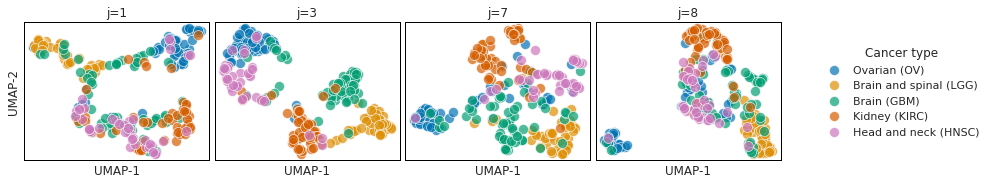

In [61]:
resolutions = [1,3,7,8]
sources = ["h_j"]

df_fig1 = df_emb[df_emb["resolution"].isin([f"{i}" for i in resolutions])]
df_fig1 = df_fig1[df_fig1["source"].isin(sources)]

g = sns.FacetGrid(df_fig1, row="source", col="resolution", hue="Cancer type", margin_titles=True, despine=False, height=3, aspect=1, sharex=False, sharey=False,legend_out=True)
g.map(sns.scatterplot, "UMAP-1", "UMAP-2", alpha=0.7, s=100).add_legend()
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

g.set_titles(col_template="j={col_name}", row_template="")    # {row_name}

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label="UMAP-1", clear_inner=True, )
g.set_ylabels(label="UMAP-2", clear_inner=True, )
# g.fig.supxlabel("Resolution embeddings")

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    ax.set_facecolor((0, 0, 0, 0))

# Adjust margins
# plt.tight_layout()
g.figure.subplots_adjust(wspace=0.03, hspace=0.03)
# sns.legend(loc='right',bbox_to_anchor=(1,0.5))

        
plt.savefig("classifier_embeddings.png", dpi=500, format='png', transparent=True)

## Visualisation of self-attention (in paper)

In [75]:
# Checking how many hops were really needed

# a_summ = torch.std(A, dim=1).cpu().numpy()
# for j in range(J):
#     plt.figure()
#     plt.hist(a_summ[:, j])

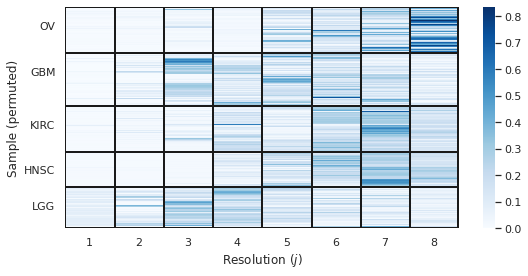

In [64]:
from sklearn.cluster import SpectralBiclustering

# Order samples by label
permute_idx = np.argsort(lbls)
ord_lbls = lbls[permute_idx]
ord_attention = A[permute_idx, :, :]

# average over attention hops:   [batch_size, num_multiscales]
ord_attention = torch.mean(ord_attention, dim=1).cpu().numpy()  

# Nested ordering (by biclustering attention)
attention_new = np.zeros_like(ord_attention)
for _lbl in np.unique(ord_lbls):
    lbl_idx = np.where(ord_lbls == _lbl)[0]
    atn_cls = ord_attention[lbl_idx, :]
    biclustering = SpectralBiclustering(n_clusters=(ord_attention.shape[1], 1), method="log", random_state=0)
    biclustering.fit(atn_cls)
    atn_cls = atn_cls[np.argsort(biclustering.row_labels_)]
    attention_new[lbl_idx, :]  = atn_cls#[:, np.argsort(biclustering.column_labels_)]
attention = attention_new

# Plot
fig, ax = plt.subplots(1, 1, figsize=(8,4))
sns.heatmap(attention, ax=ax, cmap='Blues', vmin=0, yticklabels=False)   # vmax=1

# Add horizontal lines
y_tick_locations = [np.where(ord_lbls == _lbl)[0][0] for _lbl in np.unique(ord_lbls)]
for y_tick in y_tick_locations:
    ax.hlines(y=y_tick+0.1, xmin=0, xmax=20, linewidth=2, color='k')
ax.hlines(y=attention.shape[0]-0.1, xmin=0, xmax=20, linewidth=2, color='k')

# Add vertical lines
for x_tick in [i for i in range(J)]:
    ax.vlines(x=x_tick+0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')
ax.vlines(x=attention.shape[1]-0.01, ymin=0, ymax=attention.shape[0], linewidth=2, color='k')

    
ax.set_yticks([yi+attention.shape[0]/12 for yi in y_tick_locations])
# ax.set_yticks([], minor=True)
# ax.yaxis.grid(True, which='major', lw=1, ls='-', color='k')
ax.set_yticklabels(labels_short)
ax.set_xticklabels([f"{j+1}" for j in range(J)], minor=False)

ax.set_xlabel("Resolution $(j)$")
ax.set_ylabel("Sample (permuted)")

plt.tight_layout()
plt.savefig("classifier_attention.png", dpi=500, format='png', transparent=True)


## Visualisation of the multi-resolution embedding

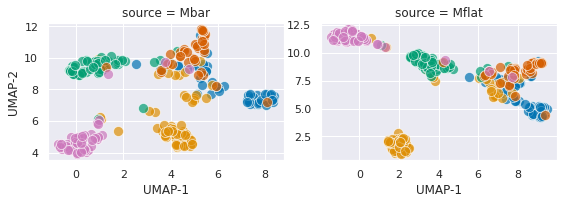

In [68]:
data = []

# UMAP of scale embeddings, alpha_j prediction, and masked input
for val, val_name in zip([Mbar, Mflat], ["Mbar", "Mflat"]):

    reducer = umap.UMAP(n_components=2)
    scaled_val = StandardScaler().fit_transform(val.reshape((val.shape[0], -1)))
    embedding = reducer.fit_transform(scaled_val)

    for i in range(embedding.shape[0]):
        data.append([embedding[i, 0], embedding[i, 1], 
                     val_name,
                     lbls[i] + 1])  

df_emb = pd.DataFrame(data, columns=["UMAP-1", "UMAP-2", "source", "class"])
df_emb.head()

# Plot
g = sns.FacetGrid(df_emb, col="source", hue="class", margin_titles=True, despine=False, height=3, aspect=4/3, sharex=False, sharey=False)
g.map(sns.scatterplot, "UMAP-1", "UMAP-2", alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)


## Plot flattened multi-resolution embeddings (in paper)

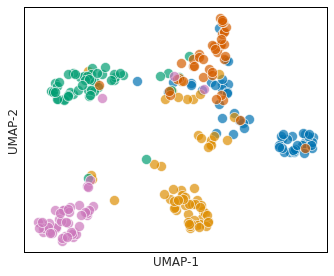

In [70]:
sources = ["Mbar"]

df_emb = df_emb[df_emb["source"].isin(sources)]
# df_emb = df_emb[df_emb["class"].isin([5, 6])]           # Zoom into subset of classes

g = sns.FacetGrid(df_emb,  col="source", hue="class", margin_titles=True, despine=False, height=4, aspect=1.2, sharex=False, sharey=False)
g.map(sns.scatterplot, "UMAP-1", "UMAP-2", alpha=0.7, s=100)
sns.despine(fig=None, ax=None, top=False, right=False, left=False, bottom=False, offset=None, trim=False)

g.set_titles(col_template="", row_template="")    # {row_name}

g.set(xticks=[])
g.set(yticks=[])
g.set_xlabels(label="UMAP-1", clear_inner=True, )
g.set_ylabels(label="UMAP-2", clear_inner=True, )

for ax in g.axes.flatten():  
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(1)
        
    ax.set_facecolor((0, 0, 0, 0))

# Adjust margins
plt.tight_layout()
        
plt.savefig("classifier_mflat.png", dpi=500, format='png', transparent=True)